# Check Common allele frequencies and how mistakes are distributed among Labs

In [1]:
import numpy as np
import os as os
import sys as sys
import multiprocessing as mp
import pandas as pd
import socket
import matplotlib.pyplot as plt
from itertools import groupby
from shutil import which
import os
import re as re
import h5py
import itertools as it

### Pick the right path (whether on cluster or at home)
socket_name = socket.gethostname()
print(f"Current machine: {socket_name}")
if socket_name == "DESKTOP-5RJD9NC":
    path = "/gitProjects/covid19_data"   # The Path on Harald's machine
if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/covid19_data/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
### Check whether required bins are available
req_bins = ["mafft"] 
for b in req_bins:
    s = which(b)
    if not s:
        print(f"Make sure to install {b} and have in path. I cannot find it!")
        
os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

Current machine: compute-a-16-163.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/covid19_data


### Define Functions

In [27]:
def filter_reliable_snps(df, frac_cov=0.75, min_alt=50,
                        alt_col="altcount", tot_col="totcount", output=True):
    """Filter to reliable SNPs
    df: Input dataframe (allele spectrum)
    frac_cov: """
    max_count = np.max(df_spec[tot_col])  # Max. Coverage
    idx = (df[alt_col]>min_alt) & (df[tot_col]>(frac_cov*max_count))
    df = df[idx].copy()
    if output:
        print(f"Max Covered: {max_count} Inds")
        print(f"Cutoff: {frac_cov*max_count}")
        print(f"Filtered to {np.sum(idx)} / {len(idx)} Variants")
    return df

def load_h5(path = "./output/h5/covid_seqs.h5"):
    """Load and return HDF5"""
    f = h5py.File(path, "r") # Load for Sanity Check. See below!  
    print(f"Loaded HDF5 from {path}")
    print(list(f))
    print(np.shape(f["gt"]))
    assert(np.shape(f["gt"])[0]==len(f["samples"]))
    return f

def create_int_df(f, df_snps, h5_field="gt"):
    """Produce ref derived 0/1 counts for
    allele frequency file f and variant datafram df_snps"""
    n, _ = np.shape(f[h5_field])
    l = len(df_snps)
    gt = -np.ones((n,l), dtype="int8")
    g = f[h5_field][:, df_snps["pos"]]
    ref_idx = g == df_snps["ref"].astype('|S1').values[None,:]
    alt_idx = g == df_snps["alt"].astype('|S1').values[None,:]

    ## Sanity Checks
    assert(np.sum(ref_idx, axis=0)==df_snps["refcount"].values).all()
    assert(np.sum(alt_idx, axis=0)==df_snps["altcount"].values).all()

    gt[ref_idx]=0
    gt[alt_idx]=1
    return gt

# Load common alleles & clean data

In [3]:
path_spectrum = "./output/tables/allele_spectrum.tsv"
df_spec = pd.read_csv(path_spectrum, sep="\t")
print(f"Loaded {len(df_spec)} Loci Statistics from {path_spectrum}")
df_spec["totcount"] = (df_spec["refcount"] + df_spec["altcount"])  # Create the total Count
max_count = np.max(df_spec["totcount"])
print(f"Maximum Covered Locus: {max_count} Inds")

Loaded 29903 Loci Statistics from ./output/tables/allele_spectrum.tsv
Maximum Covered Locus: 3325 Inds


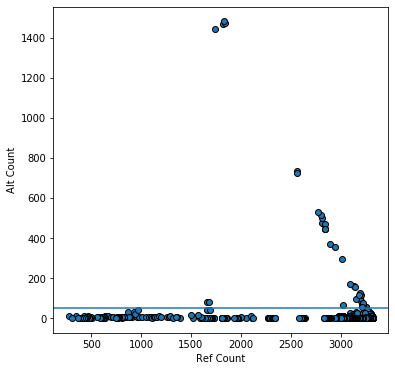

In [4]:
plt.figure(figsize=(6,6))
ax=plt.gca()
ax.scatter(df_spec["refcount"], df_spec["altcount"], ec='k')
ax.set_xlabel("Ref Count")
ax.set_ylabel("Alt Count")
ax.axhline(50)
#ax.set_xlim([2500,3300])
plt.show()

### Analyze SNPs on 0/1/-1 basis

In [29]:
df_snps = filter_reliable_snps(df_spec, frac_cov=0.75, min_alt=50)
f = load_h5(path = "./output/h5/covid_seqs.h5")
gt = create_int_df(f, df_snps)  # Create 0/1 Genotype Matrix [n,l] for df_snps Positions

### Load relevant parts of the HDF5
gt = create_int_df(f, df_snps)  # Create 0/1 Genotype Matrix [n,l] for df_snps Positions
np.sum(gt==-1, axis=0)

Max Covered: 3325 Inds
Cutoff: 2493.75
Filtered to 34 / 29903 Variants
Loaded HDF5 from ./output/h5/covid_seqs.h5
['gt', 'samples']
(3325, 29903)


array([145,  39,  61,  35,  36,  51,  26,  23,  30,  30,  16,  40,  16,
        15,   4,   7,  15,   9,  19,  11,  78,  11,  15,  42,  29,  56,
        40,  25,  30,  36,  33,  33,  54, 233])

### Load the relevant parts of the hdf5

In [31]:
np.shape(gt)

(3325, 34)

In [61]:
def return_der_stats(g1, g2, cov_only=True):
    """Calculate and return statistics
    of ancestral/derived.
    g1, g2: Arrays of Genotypes (0/1/-1)"""
    if cov_only:
        idx = (g1>=0) & (g2>=0)
        g1, g2 = g1[idx], g2[idx] 
    d1 = (g1 == 1)
    d2 = (g2 == 1)
    
    td1, td2 = np.sum(d1), np.sum(d2)
    min_d = np.min([d1,d2])
    min_idx = np.argmin([d1,d2])
    both_d = np.sum(d1 & d2)
    return both_d, min_d, min_idx

In [70]:
l = np.shape(gt)[1]
pw = int(l*(l-1)/2)
both_ds = np.zeros(pw, dtype="int")
min_ds = np.zeros(pw, dtype="int")

for i, (i1,i2) in enumerate(it.combinations(range(l),2)):
    g1, g2 = gt[:,i1], gt[:,i2]
    both_ds[i], min_ds[i], min_idx = return_der_stats(g1, g2)
    frac_ds = both_ds[i] / min_ds[i]
    if frac_ds[i]<0.5:
        error_stat = [1, 1] # Both derived
    else:
        if min_idx == 0:
            error_stat = [1,0]
        elif min_idx == 1:
            error_stat = [0,1]
            
        else:
            raise RuntimeError("Something went wrong with the min Index")
        

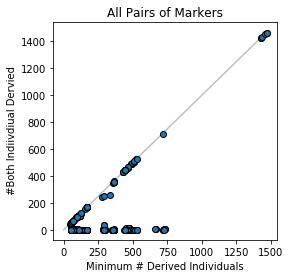

In [88]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.scatter(min_ds, both_ds, ec="k", zorder=1)
ax.set_xlabel("Minimum # Derived Individuals")
ax.set_ylabel(" #Both Indiivdiual Dervied")
ax.set_title("All Pairs of Markers")
m = np.max(min_ds)
ax.plot([0,m],[0,m], c="silver", zorder=0)
#ax.set_xlim([0,100])
#ax.set_ylim([0,100])
plt.show()

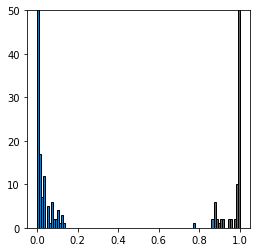

In [87]:
plt.figure(figsize=(4,4))
ax = plt.gca()
ax.hist(both_ds/min_ds, bins=100, ec="k")
ax.set_ylim([0,50])
plt.show()


# Area 51

In [71]:
np.sum(gt==1, axis=0)

array([1444,   70,  368,   86,  159,  101,  102,  156, 1470,  734,   54,
        476, 1472,  296,  117,  126,  498,  514,  532,   56,   96, 1482,
        468,   59,  355,  172,  724,   76,  114,  445,  444,  444,   53,
         67])

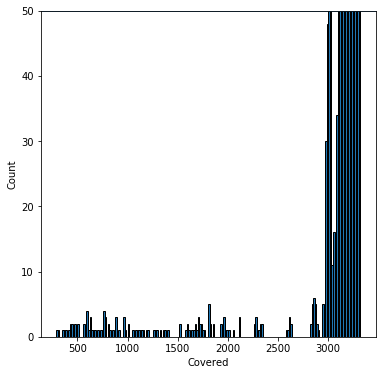

In [28]:
plt.figure(figsize=(6,6))
ax=plt.gca()
ax.hist(df_spec["totcount"], ec="k", bins=200)
ax.set_xlabel("Covered")
ax.set_ylabel("Count")
ax.axhline(50)
#ax.set_xlim([2500,3300])
ax.set_ylim([0,50])
plt.show()

### Test Loading hdf5

In [2]:
path="/home/np29/myhdf5/2bit_uchar.h5"
f = h5py.File(path, "r") # Load for Sanity Check. See below!  
print(f"Loaded HDF5 from {path}")
print(list(f))

Loaded HDF5 from /home/np29/myhdf5/2bit_uchar.h5
['2bit']


In [4]:
f["2bit"][:]

array([[0, 1],
       [2, 3],
       [0, 1]], dtype=uint8)